
# Heco.jl Example

This notebook provides an example of how to use `Heco.jl`. It covers:

- Generating a basic microstructure  
- Defining materials  
- Setting up loading conditions, tolerances, and related parameters  
- Running the computation with various options  
- Viewing and interpreting the results through a basic post-processing step  


> **Note:** The parameters used in this example (e.g., spatial discretization, tolerances, loading cases) are chosen purely for illustrative purposes.  
> They are not optimized for accuracy or performance, and no guarantees are provided regarding the quality or physical realism of the results.


In [18]:
# Import required packages
using Heco             # Main package for microstructure computation
using PyPlot           # For plotting (Matplotlib wrapper in Julia)



### Microstructure

The `Micro` module of `Heco.jl` allows for the quick generation of randomly stacked disks. The output microstructure is an array of size `(Np, Np, 1)`.  

This type of microstructure is particularly useful for studying unidirectional (UD) composites. A random seed can be specified to ensure reproducibility.


Microstructure array size: (1024, 1024, 1)
Achieved fiber volume fraction: 0.6999502182006836
Approximate fiber diameter in pixels: 68
Actual minimum distance between fibers: 0.09754264749275077


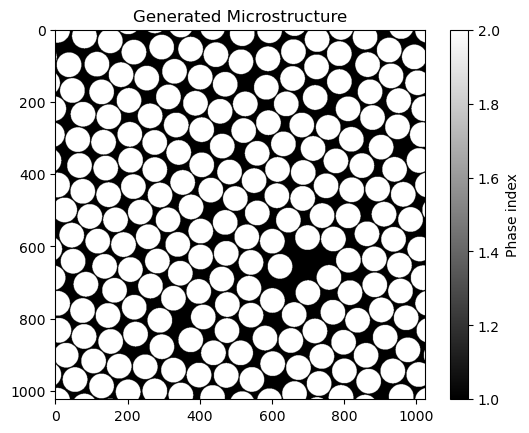

In [26]:
# Parameters for microstructure generation
nf = 200        # Number of fibers
f = 0.7         # Target fiber volume fraction
dmin = 0.1      # Minimum distance between fibers (relative to fiber radius)
Np = 1024       # Spatial resolution (number of pixels in each direction)

# Generate the microstructure using randomly stacked disks
info, microstructure = Micro.gen_2d_random_disks(nf, f, dmin, Np, seed=123)

# Display some useful information
println("Microstructure array size: $(size(microstructure))")
println("Achieved fiber volume fraction: $(info[:f])")
println("Approximate fiber diameter in pixels: $(info[:Dfpix])")
println("Actual minimum distance between fibers: $(info[:dmin])")

# Visualize the generated microstructure
plt.figure()
plt.imshow(microstructure[:, :, 1], cmap="gray")
plt.colorbar(label="Phase index")
plt.title("Generated Microstructure")
gcf()  # Display the plot (similar to plt.show() in Jupyter)


### Material Phases

In `Heco.jl`, materials can be defined as either **isotropic** (`IE`) or **transversely isotropic** (`ITE`). Both types accept parameters via keyword arguments, making them convenient to instantiate.

#### Isotropic Example (`IE`)
```julia
mat1 = IE(kappa = 10.0, mu = 2.0)
mat2 = IE(E = mat1.E, nu = mat1.nu)

mat1 == mat2  # true
```

You can also use complex values:
```julia
mat3 = IE(mu = 5.0 + 1im, E = 200.0 + 10im)
```

#### Transversely Isotropic Example (`ITE`)
```julia
mat4 = ITE(El = 230.0, Et = 15.0, nul = 0.2, mul = 15.0, mut = 10.0)
mat5 = ITE(El = 230.0, Et = 15.0, nul = 0.2, mul = 15.0, nut = mat4.nul)

mat4 == mat5  # true
```

You can also define `ITE` materials using the alternative stiffness parameters:
```julia
mat6 = ITE(k = 2.0, l = 1.0, m = 5.0, n = 5.0, p = 1.0)
```

> All values must be of a consistent type (e.g., all `Float64`, `ComplexF64`, `Float32`, etc.). A consistency check is performed upon creation to ensure the parameters are physically coherent — but **this does not guarantee the resulting stiffness tensor is positive-definite**.


In [20]:
matrix = IE(E=4.0, nu=0.4)
fibre = ITE(El=230.0, Et=15.0, nul=0.2, mul=15.0, mut=10.0)
;



### Computation

To run a homogenization computation in `Heco.jl`, the following arguments are required:

- **`phases`**: the microstructure (an array where each voxel's value is an index into the material list)  
- **`material_list`**: a vector of material definitions, where indices match those in `phases`  
- **`loading_type`**: the type of macroscopic loading to apply (e.g., strain or stress)  
- **`loading_list`**: a list of loading vectors to apply  
- **`tols`**: convergence tolerances (e.g., on stress and strain)

The `homogenize` function also supports several keyword arguments for advanced configuration:

```julia
homogenize(
    phases::Array{<:Integer,3},
    material_list::Vector{<:Elastic},
    loading_type::LoadingType,
    loading_list::Vector{<:AbstractVector{<:Number}},
    tols::Vector{<:Real};
    verbose_fft::Bool = false,
    verbose_step::Bool = false,
    c0::Union{Nothing, <:Elastic} = nothing,
    Nit_max::Int64 = 1000,
    keep_fields::Bool = false,
    precision::Precision = Simple,
    gpu::Bool = true
)
```

#### Keyword Argument Descriptions

- `verbose_fft`: Prints convergence info during iterations.
- `verbose_step`: Prints summary info at the end of each loading case.
- `c0`: Optionally specify a custom reference material (used internally in the iterative solver).
- `Nit_max`: Maximum number of iterations allowed.
- `keep_fields`: If `true`, saves the local strain and stress fields for each loading step.
- `precision`: Selects numerical precision (`Simple` = `Float32`, `Double` = `Float64`).  
  > *Note:* Double precision on GPU is generally **not supported**.
- `gpu`: Enables GPU acceleration if available. Set to `false` to force CPU computation.



In [21]:
# Define the list of materials used in the microstructure
material_list = [matrix, fibre] # index 1 -> matrix, index 2 -> fibre


# Define the list of macroscopic loadings [X11, X22, X33, X23, X13, X12]
loading_list = [
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # Pure axial strain in x-direction
    [1.0, 1.0, 0.0, 0.0, -1.0, 0.0]  # Combined loading
]

# Define the convergence tolerances: [equilibrium_error, loading_error]
tols = [1e-6, 1e-4]
;

2-element Vector{Float64}:
 1.0e-6
 0.0001

In [22]:
# Run the homogenization with CPU
sol = homogenize(
    microstructure,
    material_list,
    Strain,            # Type of loading: Strain or Stress
    loading_list,
    tols;
    verbose_fft = true,
    verbose_step = true,
    gpu = false,        # Set to true to use GPU if available
    keep_fields=true,
);


It: 1 EQ: 7.7e-02 

┌ Info: c0
│   c0 = ITE{Float64}(44.69039797412585, 4.317969833005744, 7.180852140002837, 119.28401408623856, 8.42307969670292, 118.86681342739585, 24.73503430486317, 0.04830981629997673, 0.7222910194091114, 8.42307969670292, 7.180852140002837)
└ @ Heco /home/valmalette/Documents/Heco/src/solver.jl:24


LO: 0.0e+00 | E11: 1.00000e+00 E22:-3.12816e-12 E33: 0.00000e+00 E23: 0.00000e+00 E13: 0.00000e+00 E12: 4.99040e-12 | S11: 1.25710e+01 S22: 1.39652e-01 S33: 3.38616e+00 S23: 0.00000e+00 S13: 0.00000e+00 S12:-1.13050e-03
It: 2 EQ: 1.7e-02 LO: 0.0e+00 | E11: 1.00000e+00 E22: 1.62170e-11 E33: 0.00000e+00 E23: 0.00000e+00 E13: 0.00000e+00 E12: 9.00308e-13 | S11: 1.20600e+01 S22: 6.42009e-01 S33: 3.37344e+00 S23: 0.00000e+00 S13: 0.00000e+00 S12:-1.24955e-03
It: 3 EQ: 6.4e-03 LO: 0.0e+00 | E11: 1.00000e+00 E22:-2.86906e-11 E33: 0.00000e+00 E23: 0.00000e+00 E13: 0.00000e+00 E12: 2.16402e-12 | S11: 1.17282e+01 S22: 9.66771e-01 S33: 3.36297e+00 S23: 0.00000e+00 S13: 0.00000e+00 S12:-3.96805e-04
It: 4 EQ: 2.8e-03 LO: 0.0e+00 | E11: 1.00000e+00 E22:-4.26277e-11 E33: 0.00000e+00 E23: 0.00000e+00 E13: 0.00000e+00 E12:-8.68977e-12 | S11: 1.15157e+01 S22: 1.17343e+00 S33: 3.35433e+00 S23: 0.00000e+00 S13: 0.00000e+00 S12: 2.58572e-04
It: 5 EQ: 1.3e-03 LO: 0.0e+00 | E11: 1.00000e+00 E22:-3.80606e-11 

In [23]:
# Run the homogenization with GPU
sol = homogenize(
    microstructure,
    material_list,
    Strain, # or Stress
    loading_list,
    tols;
    verbose_fft=true,
    verbose_step=true,
    gpu=true,
    keep_fields=true,
);

It: 1 EQ: 7.7e-02 LO: 0.0e+00 | E11: 1.00000e+00 E22:-4.77485e-11 E33: 0.00000e+00 E23: 0.00000e+00 E13: 0.00000e+00 E12:-1.89289e-11 | S11: 1.25710e+01 S22: 1.39617e-01 S33: 3.38616e+00 S23: 0.00000e+00 S13: 0.00000e+00 S12:-1.13049e-03
It: 2 EQ: 1.7e-02 LO: 0.0e+00 | E11: 1.00000e+00 E22:-2.09184e-11 E33: 0.00000e+00 E23: 0.00000e+00 E13: 0.00000e+00 E12: 2.91038e-11 | S11: 1.20601e+01 S22: 6.41938e-01 S33: 3.37343e+00 S23: 0.00000e+00 S13: 0.00000e+00 S12:-1.25009e-03
It: 3 EQ: 6.4e-03 LO: 0.0e+00 | E11: 1.00000e+00 E22: 7.82165e-11 E33: 0.00000e+00 E23: 0.00000e+00 E13: 0.00000e+00 E12:-2.91038e-11 | S11: 1.17283e+01 S22: 9.66674e-01 S33: 3.36297e+00 S23: 0.00000e+00 S13: 0.00000e+00 S12:-3.97869e-04


┌ Info: c0
│   c0 = ITE{Float64}(44.69039797412585, 4.317969833005744, 7.180852140002837, 119.28401408623856, 8.42307969670292, 118.86681342739585, 24.73503430486317, 0.04830981629997673, 0.7222910194091114, 8.42307969670292, 7.180852140002837)
└ @ Heco /home/valmalette/Documents/Heco/src/solver.jl:24


It: 4 EQ: 2.8e-03 LO: 0.0e+00 | E11: 1.00000e+00 E22:-3.63798e-12 E33: 0.00000e+00 E23: 0.00000e+00 E13: 0.00000e+00 E12: 0.00000e+00 | S11: 1.15158e+01 S22: 1.17332e+00 S33: 3.35433e+00 S23: 0.00000e+00 S13: 0.00000e+00 S12: 2.57266e-04
It: 5 EQ: 1.3e-03 LO: 0.0e+00 | E11: 1.00000e+00 E22:-1.49157e-10 E33: 0.00000e+00 E23: 0.00000e+00 E13: 0.00000e+00 E12: 0.00000e+00 | S11: 1.13705e+01 S22: 1.31383e+00 S33: 3.34719e+00 S23: 0.00000e+00 S13: 0.00000e+00 S12: 7.51336e-04
It: 6 EQ: 6.1e-04 LO: 0.0e+00 | E11: 1.00000e+00 E22:-1.79170e-10 E33: 0.00000e+00 E23: 0.00000e+00 E13: 0.00000e+00 E12:-2.91038e-11 | S11: 1.12703e+01 S22: 1.40998e+00 S33: 3.34127e+00 S23: 0.00000e+00 S13: 0.00000e+00 S12: 1.08159e-03
It: 7 EQ: 3.0e-04 LO: 0.0e+00 | E11: 1.00000e+00 E22:-4.27463e-11 E33: 0.00000e+00 E23: 0.00000e+00 E13: 0.00000e+00 E12: 1.16415e-10 | S11: 1.12000e+01 S22: 1.47700e+00 S33: 3.33636e+00 S23: 0.00000e+00 S13: 0.00000e+00 S12: 1.29638e-03
It: 8 EQ: 1.5e-04 LO: 0.0e+00 | E11: 1.00000e+00

### Exploit results

#### Macro quantities

`sol[:steps]` contains macro quantities and information relative to the computation.

In [24]:
n_loading = length(sol[:steps][:it])

for i in 1:n_loading
    
    println("Loading $i")
    println("E = <ϵ> = $(sol[:steps][:E][:,i])")
    println("Σ = <σ> = $(sol[:steps][:S][:,i])")
    println("EΣ  = $(sol[:steps][:ES][i])")

    println("Converged in $(sol[:steps][:it][i]) iterations")
    println("Final equilibrium error: $(sol[:steps][:err_equi][i])")
    println("Final loading error: $(sol[:steps][:err_load][i])")

    println()
end


Loading 1
E = <ϵ> = Float32[1.0, -1.6643753f-10, 0.0, 0.0, 0.0, -5.820766f-11]
Σ = <σ> = Float32[11.026294, 1.6362392, 3.3150218, 0.0, 0.0, 0.0016521704]
EΣ  = 11.026294
Converged in 18 iterations
Final equilibrium error: 7.883802481956081e-7
Final loading error: 0.0

Loading 2
E = <ϵ> = Float32[1.0, 1.0, 0.0, -2.401066f-10, -1.0, -1.4551915f-11]
Σ = <σ> = Float32[12.656834, 12.670157, 6.632891, 0.036325563, -11.722311, 0.004837785]
EΣ  = 48.771614
Converged in 19 iterations
Final equilibrium error: 9.98922132566804e-7
Final loading error: 0.0



#### Accessing Local Fields (Optional)

If the keyword `keep_fields = true` was passed to `homogenize`, the local strain and stress fields are stored in the solution dictionary:

- `sol[:eps]`: local **strain fields**
- `sol[:sig]`: local **stress fields**

These arrays have shape:

```julia
(N1, N2, N3, 6, n_loading)
```

Where:
- `N1`, `N2`, `N3` are the spatial dimensions of the microstructure (e.g., `Np × Np × 1`)
- `6` corresponds to the 6 components of strain/stress
- `n_loading` is the number of macroscopic loading cases applied


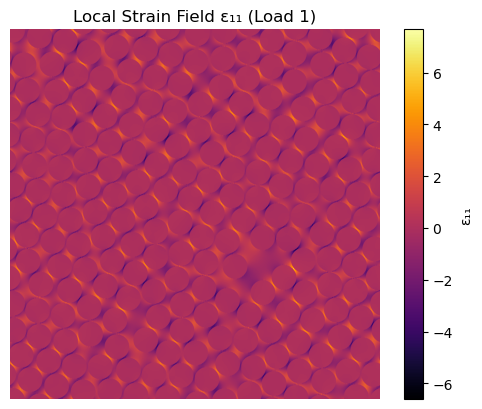

In [25]:
eps_fields = sol[:eps]
strain_11 = eps_fields[:, :, 1, 4, 2]  # Component ε₂₃, for loading case 2

plt.figure()
plt.imshow(strain_11, cmap="inferno")
plt.colorbar(label="ε₁₁")
plt.title("Local Strain Field ε₁₁ (Load 1)")
plt.axis("off")
gcf()